In [1]:
import ast
import json
import random

from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [2]:
api = wandb.Api()

In [3]:
def get_experiment_data(filters, name):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            artifact = api.artifact(f"bartekcupial/sf2_nethack/run-{run.id}-table_results:v1")
            artifact_path = Path("artifacts") / f"run-{run.id}-table_results:v1" / "table_results.table.json"
            if artifact_path.exists():
                table = wandb.Table.from_json(json.load(open(artifact_path, "r+")), artifact)
            else:
                table = artifact.get("table_results")
            df = table.get_dataframe()
            df["seed"] = run.config["seed"]
            df["train/env_steps"] = run.summary_metrics["train/env_steps"]
            df["train_dir"] = run.config["train_dir"]
            df["name"] = name
            df["exp_tag"] = ast.literal_eval(run.config["exp_tags"])[0]
            data.append(df)
        except Exception as e:
            pass

    df = pd.concat(data, axis=0).reset_index()
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
data = get_experiment_data({"config.exp_tags": "['2024_02_02_eval_full']"}, "all")

In [5]:
data["exp_tag"] = data["train_dir"].apply(lambda x: "-".join(x.split("/")[-2].split("-")[:-1]))

In [6]:
dd = pd.read_csv("notebooks/cloned_expert_500_human_monk.csv")
dd["exp_tag"] = "pretrained"
data = pd.concat([data, dd], axis=0)

In [7]:
data[["score", "exp_tag"]].groupby("exp_tag").count()

,score
exp_tag,
2024-01-23-monk-appo,500
2024-01-23-monk-appo-bc-t,389
2024-01-23-monk-appo-ks-t,499
2024-01-23-monk-appo-t,515
2024-01-29-monk-appo-ewc-t,488
pretrained,482


In [8]:
data[data["death"] == "quit"][["score", "exp_tag"]].groupby("exp_tag").mean()

,score
exp_tag,
2024-01-23-monk-appo,653.295699
2024-01-23-monk-appo-bc-t,7568.108696
2024-01-23-monk-appo-ks-t,10296.000000
2024-01-23-monk-appo-t,498.069182
2024-01-29-monk-appo-ewc-t,3030.245763
pretrained,3492.406015


In [9]:
data[data["death"] != "quit"][["score", "exp_tag"]].groupby("exp_tag").mean()

,score
exp_tag,
2024-01-23-monk-appo,875.458599
2024-01-23-monk-appo-bc-t,7202.364431
2024-01-23-monk-appo-ks-t,10582.916840
2024-01-23-monk-appo-t,1230.939086
2024-01-29-monk-appo-ewc-t,4096.883784
pretrained,5215.005731


In [10]:
data.loc[data["death"].str.contains("lack of food|starvation"), "death"] = "lack of food / starvation"

In [11]:
method_translator = {
    "pretrained": "Cloned Policy $\pi_*$",
    "2024-01-23-monk-appo": "From scratch",
    "2024-01-23-monk-appo-t": "Fine-tuning",
    "2024-01-23-monk-appo-ks-t": "Fine-tuning + KS",
    # "2024-01-23-monk-appo-bc-t": "Fine-tuning + BC",
    # "2024-01-29-monk-appo-ewc-t": "Fine-tuning + EWC",
}

In [12]:
all_death = dict()

for method_tag, method_name in method_translator.items():
    method_data = data[data["exp_tag"] == method_tag]
    unique, counts = np.unique(method_data["death"].to_numpy(), return_counts=True)

    c = counts[counts.argsort()[::-1]] / len(method_data) * 100
    u = unique[counts.argsort()[::-1]]
    df = pd.DataFrame({"chance": c, "death": u})

    for death in list(df[:10]["death"]):
        all_death[death] = 0

In [13]:
len(all_death)

29

In [14]:
def generate_viridis_palette(num_colors):
    color_palette = dict(zip(np.arange(10), list(mcolors.TABLEAU_COLORS.values())))
    cmap = [plt.get_cmap('tab20b')(i) for i in range(20)]

    for i in range(10, num_colors):
        color_palette[i] = mcolors.to_hex(cmap[i - 10])

    return color_palette

color_palette = generate_viridis_palette(30)

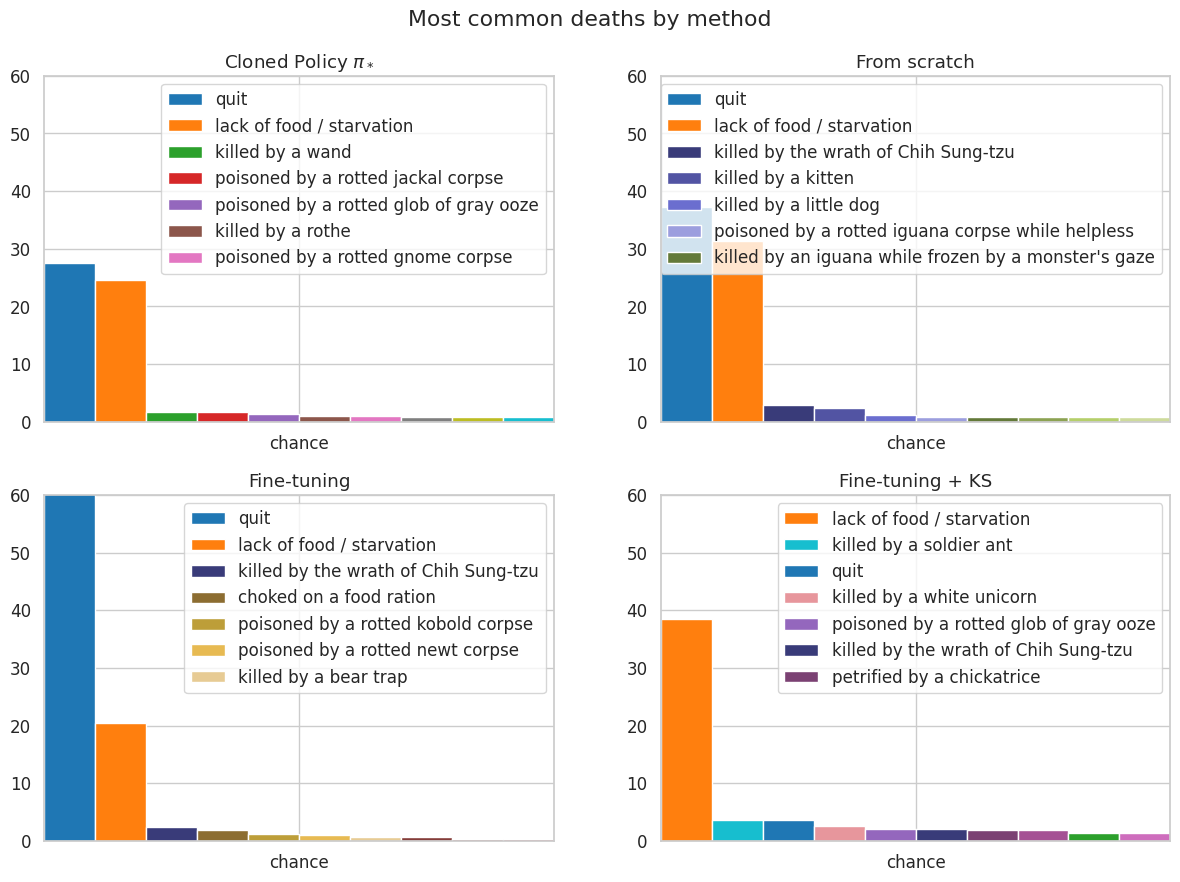

In [15]:
colors = {death: color_palette[i] for i, death in enumerate(all_death.keys())}

sns.set(font_scale=1.1)
sns.set_style('whitegrid')

n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 9))
axes = axes.flatten()

sns_colors = sns.color_palette()

for (method_tag, method_name), ax in zip(method_translator.items(), axes):
    method_data = data[data["exp_tag"] == method_tag]
    unique, counts = np.unique(method_data["death"].to_numpy(), return_counts=True)

    c = counts[counts.argsort()[::-1]] / len(method_data) * 100
    u = unique[counts.argsort()[::-1]]
    df = pd.DataFrame({"chance": c, "death": u})
    
    # Plot the bar chart with causes as vertical labels
    df_20 = df[:10]
    df_20.set_index('death').T.plot(kind='bar', rot=0, ax=ax, title=method_name, color=[colors[death] for death in df_20['death']])
    ax.set_ylim(0, 60)
    ax.set_xlim(-0.25, 0.25)

    # Get the top 5 legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    top5_handles = handles[:7]
    top5_labels = labels[:7]

    # Set the legend
    ax.legend(top5_handles, top5_labels)


fig.suptitle("Most common deaths by method")
plt.tight_layout()
plt.show()